# LSTM + Attention (Reproduction using PyTorch)
Original Code: https://github.com/ZhenghuaNTU/RUL-prediction-using-attention-based-deep-learning-approach/blob/master/code_FD004.py#L165

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine ñ i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true RemainingUseful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)	unit number 
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  1


Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ìDamage Propagation Modeling for Aircraft Engine Run-to-Failure Simulationî, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.


# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn import preprocessing
from sklearn import linear_model
from scipy import interpolate

# Preprocessing

In [2]:
col_names = ['unit_number', 'time']+[f"operational_setting_{i}" for i in range(1,4)]+[f"sensor_measurement_{i}" for i in range(1,22)]

# Import training & testing data
train_df1_raw = pd.read_csv("./train_FD001.txt"
                            , delimiter='\s+'
                            , header=None
                            , names=col_names)

test_df1_raw = pd.read_csv("./test_FD001.txt" 
                            , delimiter='\s+'
                            , header=None
                            , names=col_names)

test_df1_rul = pd.read_csv("./RUL_FD001.txt"
                            , delimiter='\s+'
                            , header=None
                            , names=["rul"])

# Inspect training data
train_df1_raw

,unit_number,time,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [3]:
# Inspect test data
test_df1_raw

,unit_number,time,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


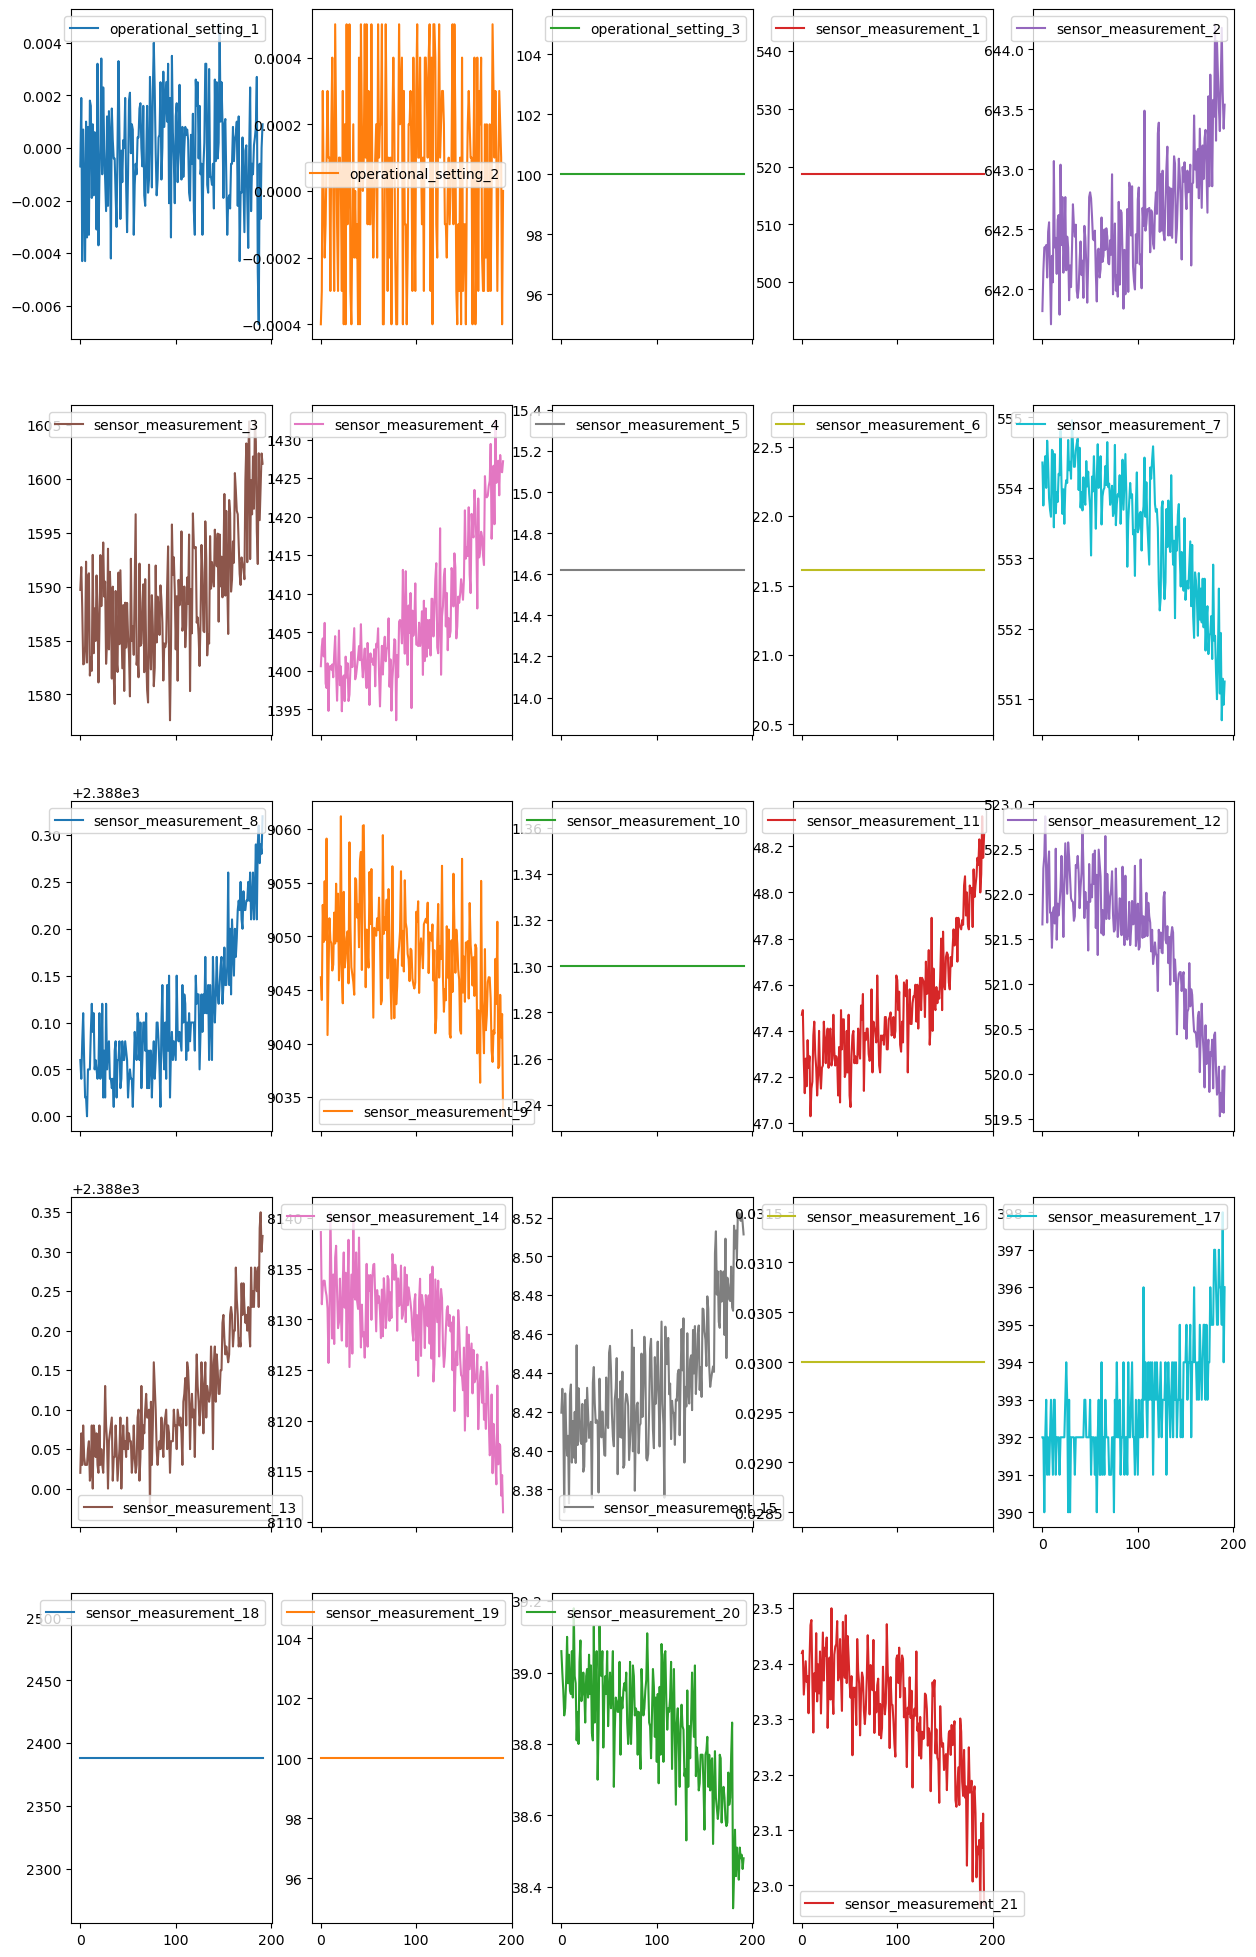

In [4]:
# Draw the trend of all features
unit1_df = train_df1_raw[train_df1_raw["unit_number"] == 1].iloc[:,2:]

axes = unit1_df.plot(subplots=True, layout=(6, 5), figsize=(15, 5 * 6), legend=True)
plt.show()

In [5]:
# Drop features that are constant throughout time
col_to_drop = ["operational_setting_3"] + [f"sensor_measurement_{i}" for i in [1, 5, 6, 10, 16, 18, 19]]
train_df1_raw.drop(col_to_drop, axis=1, inplace=True)
test_df1_raw.drop(col_to_drop, axis=1, inplace=True)

train_df1_raw

,unit_number,time,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [6]:
# Normalize operational_settings & seansor measurements
min_max_scaler = preprocessing.MinMaxScaler()
# x_std = (x – x.min(axis=0)) / (x.max(axis=0) – x.min(axis=0))
# x_scaled = x_std * (max – min) + min
train_df1_raw.iloc[:,2:] = min_max_scaler.fit_transform(train_df1_raw.iloc[:,2:])
test_df1_raw.iloc[:,2:] = min_max_scaler.transform(test_df1_raw.iloc[:,2:])

train_df1_nor = train_df1_raw
test_df1_nor = test_df1_raw

train_df1_nor

,unit_number,time,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466


In [7]:
# Calculate RUL for each time step
train_df1_nor['total_useful_life'] = train_df1_nor.groupby('unit_number')['unit_number'].transform('count')
train_df1_nor['rul'] = train_df1_nor['total_useful_life'] - train_df1_nor['time']
train_df1_nor.drop('total_useful_life', axis = 1, inplace = True)

In [8]:
# Re-order columns
train_df1_nor = train_df1_nor[['unit_number',
 'time',
 'rul',
 'operational_setting_1',
 'operational_setting_2',
 'sensor_measurement_2',
 'sensor_measurement_3',
 'sensor_measurement_4',
 'sensor_measurement_7',
 'sensor_measurement_8',
 'sensor_measurement_9',
 'sensor_measurement_11',
 'sensor_measurement_12',
 'sensor_measurement_13',
 'sensor_measurement_14',
 'sensor_measurement_15',
 'sensor_measurement_17',
 'sensor_measurement_20',
 'sensor_measurement_21',
]]

train_df1_nor

,unit_number,time,rul,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
0,1,1,191,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1,2,190,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1,3,189,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1,4,188,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1,5,187,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,4,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500
20627,100,197,3,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197
20628,100,198,2,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991
20629,100,199,1,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466


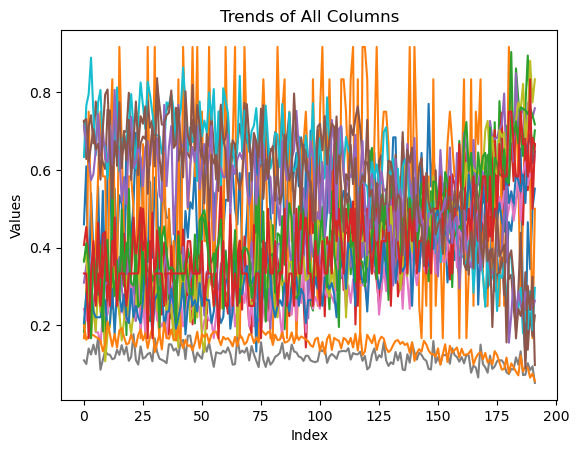

In [9]:
# Plot normalized features (unit 1)
fig, ax = plt.subplots()

# Loop through each column (except for non-numeric ones if any)
for column in train_df1_nor.columns[3:]:
    ax.plot(train_df1_nor[column][train_df1_nor["unit_number"] == 1], label=column)

# Adding legend, title and labels
ax.set_title('Trends of All Columns')
ax.set_xlabel('Index')
ax.set_ylabel('Values')

# Show the plot
plt.show()

In [10]:
window_size = 30 #sliding windows size
max_rul = 130.0 #max RUL for training

# Note that, a piece-wise linear RUL, is used instead of the true RUL for training data, 
# which means that if the true RUL is larger than the maximal RUL, it will be set to the maximal RUL.


# Data segmentation for training data

train_x = []
train_y = []

for i in range(1,101): #loop through units
    data_temp = train_df1_nor[train_df1_nor["unit_number"] == i].reset_index(drop=True) #data for unit i
    for j in range(len(data_temp) - window_size + 1):
        train_x.append(np.array(data_temp.iloc[j:j+window_size,3:]).tolist())
        train_rul = data_temp["rul"][j+window_size-1]
        train_rul = min(train_rul, max_rul)
        train_y.append(train_rul)

train_x, train_y = np.array(train_x), np.array(train_y)
train_y = train_y/max_rul # normalize to 0-1 for training

assert(len(train_x) == len(train_y))
print(len(train_x))
print(type(train_x))
print(train_y.shape)

17731
<class 'numpy.ndarray'>
(17731,)


In [11]:
# Data segmentation for validation data
valid_x = []
valid_y = []
test_rul = list(test_df1_rul["rul"])

for i in range(1,101): #loop through units in test data
    data_temp = test_df1_nor[test_df1_nor["unit_number"] == i].reset_index(drop=True) #data for unit i
    data_temp = np.array(data_temp) #transform to numpy array
    '''
    The original paper used spline interpolation to handle short sequence, 
    however we found out that there is no sequence with lenghth less than the chosen window size (30)
    '''
    # Handling short sequences
    if len(data_temp) < window_size:
        # Spline interpolation
        data_temp_a = []
        for myi in range(data_temp.shape[1]):
            x1 = np.linspace(0, window_size-1, len(data_temp) )
            x_new = np.linspace(0, window_size-1, window_size)
            tck = interpolate.splrep(x1, data_temp[:,myi])
            a = interpolate.splev(x_new, tck)
            data_temp_a.append(a.tolist())
        data_temp_a = np.array(data_temp_a)
        data_temp = data_temp_a.T
        data_temp = data_temp[:,2:]
    else:
        # Only one data window to the last sensor measurements for each engine is used as the testing sample
        data_temp = data_temp[-window_size:,2:]

    valid_x.append(data_temp.tolist())
    valid_y.append(min(test_rul[i-1], max_rul))

valid_x, valid_y = np.array(valid_x), np.array(valid_y)

assert(len(valid_x) == len(valid_y))
print(len(valid_x))
print(type(valid_x))
print(valid_x.shape)

100
<class 'numpy.ndarray'>
(100, 30, 16)


In [12]:
train_x[0].shape[1]

16

In [18]:
# Hand crafted feature: mean & trend
regr = linear_model.LinearRegression()

def hc_feature_extract(data):
    """
    hc_feature_extract extracts the mean & trend coefficient of linear regression from 
    sensory data.  The mean value shows the magnitude of sensory data, and the trend 
    coefficient indicates the degradation of sensory data. These two simple handcrafted 
    features have been shown to be effective for RUL prediction.
    
    param: data: numpy array
    return: features: a list [mean, trend]
    """
    hc_features = [] #[mean, trend]
    for i in range(data.shape[1]):
        hc_features.append(np.mean(data[:,i]))#mean
        x = np.array(range(data.shape[0])).reshape(-1, 1)
        regr.fit(x, np.ravel(data[:,i]))#trend
        hc_features+list(regr.coef_)
    return hc_features

train_x_hc_features = []
valid_x_hc_features = []
for i in range(len(train_x)):
    data_temp = train_x[i]
    train_x_hc_features.append(hc_feature_extract(data_temp))

for i in range(len(valid_x)):
    data_temp = valid_x[i]
    valid_x_hc_features.append(hc_feature_extract(data_temp))

In [20]:
scale = preprocessing.StandardScaler().fit(train_x_hc_features)
train_x_hc_features = scale.transform(train_x_hc_features)
valid_x_hc_features = scale.transform(valid_x_hc_features)

# Model

In [21]:
# Train & test split
# Use 70% of the data as training (12412:5319)
test_x = torch.tensor(train_x[12412:], dtype=torch.float32)
test_y = torch.tensor(train_y[12412:], dtype=torch.float32)

train_x = torch.tensor(train_x[:12412], dtype=torch.float32)
train_y = torch.tensor(train_y[:12412], dtype=torch.float32)

valid_x = torch.tensor(valid_x, dtype=torch.float32)
valid_y = torch.tensor(valid_y, dtype=torch.float32)

In [22]:
import torch 
import torch.nn as nn

#step 3: creATING THE MODEL
class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model 
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True) 

        # Output a single value
        self.fc = nn.Linear(hidden_d, 1)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

    
hidden_dim = 50
layer_dim = 1
learning_rate = 0.001

model = LSTMModel(input_d=16, hidden_d=hidden_dim, layer_d=layer_dim)

error = nn.MSELoss()  # MSE Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Using Adam optimizer

In [23]:
# Training Loop
num_epochs = 20  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear the gradients
    outputs = model(train_x)
    loss = error(outputs, train_y.view(-1, 1))  # Adjust the shape of train_y to match output
    loss.backward()  # Backpropagation
    optimizer.step()  # Update the weights

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    predicted = model(valid_x)
    test_loss = torch.sqrt(error(predicted*max_rul, valid_y.view(-1, 1)))  # Calculating RMSE
    print(f'Test RMSE: {test_loss.item()}')

Epoch 1/20, Loss: 0.44167453050613403
Epoch 2/20, Loss: 0.4068831205368042
Epoch 3/20, Loss: 0.3737289011478424
Epoch 4/20, Loss: 0.342196524143219
Epoch 5/20, Loss: 0.3122868537902832
Epoch 6/20, Loss: 0.28400182723999023
Epoch 7/20, Loss: 0.2573665678501129
Epoch 8/20, Loss: 0.23244896531105042
Epoch 9/20, Loss: 0.20937635004520416
Epoch 10/20, Loss: 0.18835480511188507
Epoch 11/20, Loss: 0.16968479752540588
Epoch 12/20, Loss: 0.1537681668996811
Epoch 13/20, Loss: 0.14109568297863007
Epoch 14/20, Loss: 0.13219285011291504
Epoch 15/20, Loss: 0.12747260928153992
Epoch 16/20, Loss: 0.12691053748130798
Epoch 17/20, Loss: 0.1295841485261917
Epoch 18/20, Loss: 0.13356952369213104
Epoch 19/20, Loss: 0.13670635223388672
Epoch 20/20, Loss: 0.1376163214445114
Test RMSE: 47.46212387084961
